# Monoaural source separation using NMF with Frobenius norm

In the associated paper, an analysis of the separation of sources using the Frobenius norm, KL divergence and the proposed algorithm is provided. In this, we perform separatiion using only the Frobenius norm, using the scikit learn implementation and the local implementation in tools.py.

In [1]:
import os
from os import listdir
from os.path import join
import sys

import librosa
import librosa.display
from librosa.core import resample
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import scipy
from scipy.io.wavfile import write
from sklearn.decomposition import NMF


# relative imports as the directory structure is
# blah-blah/source_separation/examples,
# blah-blah/source_separation/nmf,
sys.path.insert(0,"../../source_separation/")
from nmf.nmf_local import *
from tools.basic_functions import *
#sys.path.insert(0,"/home/milind/projects/source_separation/nmf")
#sys.path.insert(0,"/home/milind/projects/source_separation/tools")
#from ..nmf.nmf_local import *
#from ..tools.basic_functions import *

figsize = (10,8)
matplotlib.rcParams.update({'font.size': 22})

In [2]:
path_audio = "orig4.wav"
path_rescaled_components = "orig4_rescaled/"

# The audio signal

The audio is created by mixing 7 different instruments. The time domain signal is displayed below.

In [3]:
# testing it with scipy
# produces a scaling constant wrt librosa read
f, signal = scipy.io.wavfile.read("orig4.wav")
print(f,signal)

44100 [0 0 0 ... 3 0 2]


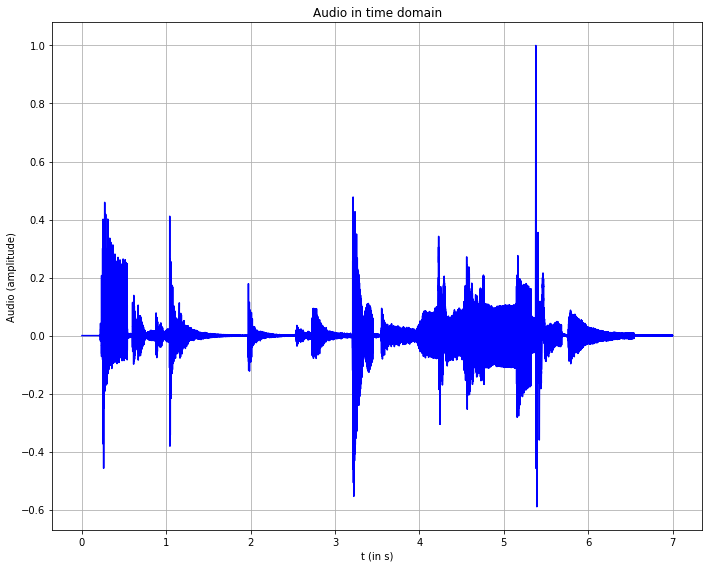

[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 9.1552734e-05 0.0000000e+00
 6.1035156e-05]


In [4]:
# loading audios
fs_target = 44100
audio, fs = librosa.load(path_audio,sr = fs_target)
# time domain representation
x = np.arange(len(audio))/fs_target
plotfigure(figsize, "t (in s)", "Audio (amplitude)", "Audio in time domain",x,audio,style= "b-" )
print(audio)

[ True  True  True ... False  True False]


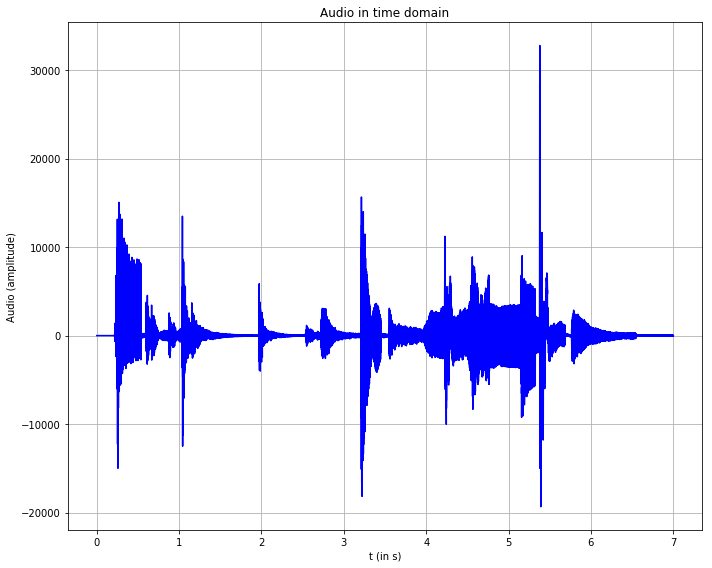

In [5]:
print(signal == (audio/np.min(audio)))
plotfigure(figsize, "t (in s)", "Audio (amplitude)", "Audio in time domain",x,signal,style= "b-" )

The parameters are set using the values provided in the paper [1].

In [6]:
# fft details in time units
frame_size = 40e-3
overlap = 0.5
dft_size = frame_size

# fft details in terms of samples
n_fft = int(frame_size*fs_target) # datatype is an advantage for future use
hop_length = int((1-overlap)*frame_size*fs_target)

# DECISION MADE HERE! for window, center, and reflect 
window = scipy.signal.hanning(n_fft)

/home/milind/miniconda3/envs/tf/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  # This is added back by InteractiveShellApp.init_path()


# The spectrogram

We obtain a STFT using the specifications provided in [1]. Thus we use a frame size of 40ms and a hop length of 29ms. The sampling rate is 44,100 Hz. A hanning window is used for the STFT.

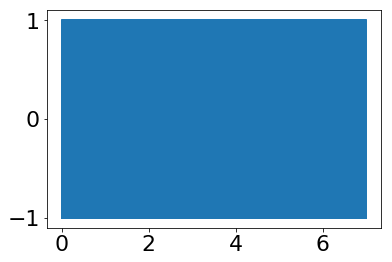

In [56]:
# mag_spec = librosa.core.stft(audio, n_fft = n_fft, hop_length = hop_length) # using default window
# D = librosa.amplitude_to_db(np.abs(mag_spec), ref=np.max)
# librosa.display.specshow(D, y_axis='log', x_axis='time')
# #librosa.display.specshow(np.abs(mag_spec), y_axis='log', x_axis='time')
# plt.show()
audio = np.sin(50000*x) 
plt.plot(x,audio)

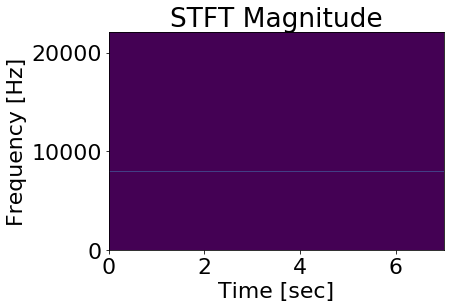

In [57]:
f, t, Zxx = scipy.signal.stft(audio, fs_target, nperseg=n_fft)
plt.pcolormesh(t, f, np.abs(Zxx), vmin=0, vmax=2)
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

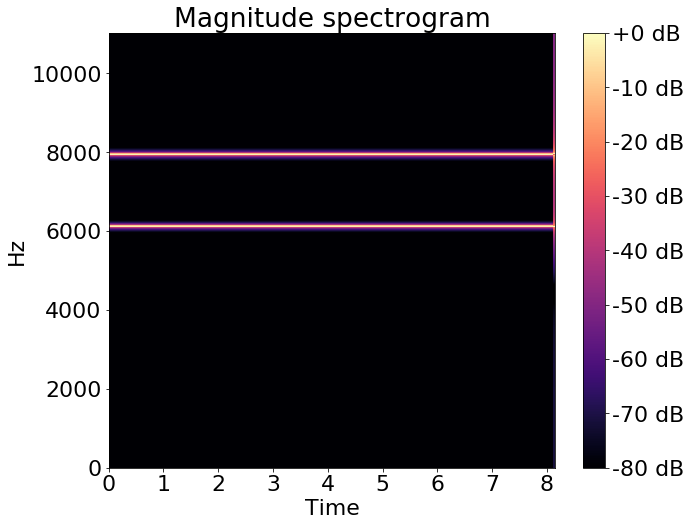

In [48]:
mag_spec = librosa.core.stft(audio, n_fft = n_fft, hop_length = hop_length) # using default window
D = librosa.amplitude_to_db(np.abs(mag_spec), ref=np.max)
plt.figure(figsize=figsize)
librosa.display.specshow(D, y_axis='linear', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title("Magnitude spectrogram")
#librosa.display.specshow(np.abs(mag_spec), y_axis='log', x_axis='time')
plt.show()

In [39]:
print((n_fft))
print(np.shape(D))

1764
(883, 351)


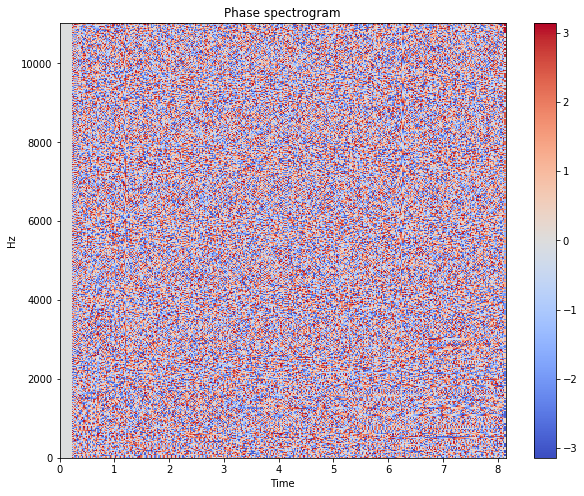

In [7]:
# attempt to plot phase spectrogram

mag_spec = librosa.core.stft(audio, n_fft = n_fft, hop_length = hop_length) # using default window
D = np.angle(mag_spec)
plt.figure(figsize=figsize)
librosa.display.specshow(D, y_axis='linear', x_axis='time')
plt.title("Phase spectrogram")
plt.colorbar()
#librosa.display.specshow(np.abs(mag_spec), y_axis='log', x_axis='time')
plt.show()

In [8]:
# # modelling componenets using Least squares norm
# model = NMF(n_components=7, init='random', random_state=0,solver="mu",beta_loss="frobenius",max_iter = 1000)
# W = model.fit_transform(np.abs(mag_spec))
# H = model.components_
# # Displaying the reconstructed spectrogram
# librosa.display.specshow(np.dot(W,H), y_axis='log', x_axis='time')

## The reconstructed spectrogram

Once the matrices $W$ amd $H$ are obtained, the magnitude spectrogram is reconstructed as 
\begin{equation}
Magnitude\ Spectrogram = WH
\end{equation}
This is displayed below.

In [9]:
# extra
D = librosa.amplitude_to_db((np.dot(W,H)), ref=np.max)
plt.figure(figsize=figsize)
librosa.display.specshow(D, y_axis='linear', x_axis='time')
#librosa.display.specshow(np.abs(mag_spec), y_axis='log', x_axis='time')
plt.title("Reconstructed magnitude spectrogram")
plt.show()

NameError: name 'W' is not defined

## The $i^{th}$ component

The magnitude spectrogram for the $i^{th}$ component is obtained. The complex spectrogram is obtained by performing an elementwise product with the phase of the original audio. We then perform an ISTFT to obtain the time domain signal. We also plot the time domain signals for the purpose of representation.

In [ ]:
# phase = np.angle(mag_spec)
# n_fft = 2*np.shape(mag_spec)[0]-1
# total = 0
# audios = []
# from scipy.io.wavfile import write
# for i in range(0,np.shape(W)[1]):
#     component= np.outer(W[:,i],(H[i,:]))
#     component = component*phase
#     audio2 = librosa.core.istft(component, hop_length=n_fft//2)
#     audios.append(audio2)
#     plt.figure()
#     plt.plot(x,audio2)
#     total = total + audio2 
#     write("/home/milind/source_separation/Monoaural_source_separation_using_Non-negative_matrix_factorization/component" +str(i) + ".wav", 44100, audio2)

phase = np.angle(mag_spec) # phase of the original signal
n_fft = 2*np.shape(mag_spec)[0]-1
total = 0
audios = []
for i in range(0,np.shape(W)[1]):
    component= np.outer(W[:,i],(H[i,:]))
    component = component*phase
    audio2 = librosa.core.istft(component, hop_length=n_fft//2)
    audios.append(audio2)
    plt.figure()
    plt.plot(x,audio2)
    total = total + audio2 
    write("/home/milind/source_separation/Monoaural_source_separation_using_Non-negative_matrix_factorization/orig4_frobenius//component" +str(i) + ".wav", 44100, audio2)
    audio2_rescaled = audio2/ np.max(audio2)
    write("/home/milind/source_separation/Monoaural_source_separation_using_Non-negative_matrix_factorization/orig4_frobenius//component" +str(i) + "_rescaled.wav", 44100, audio2_rescaled)

# The reconstructed audio

We superimpose the original time domain signal and the final reconstructed signal.

In [ ]:
# plotting sum of components and the original signal
plt.figure(figsize = (19,8))
plt.title("Superimposed signals")
plt.xlabel("time (in s)")
plt.ylabel("Amplitude")
plt.plot(x,total)
plt.plot(x,audio)
plt.show()

# Using local implementation

The above code made use of the scikit-learn implementation. Here, we attempt to use the implementation in the file nmf_local.py and check performance. We add a small positive value to the magnitude spectrogram to ensure that we don't run into divisions by zero.

In [ ]:
magnitude = np.abs(mag_spec)
nonzero = np.nonzero(magnitude)
minval = (np.min(magnitude[nonzero]))
alpha = minval/1000

In [ ]:
corrected = magnitude + alpha

In [ ]:
B,G,_ = lstfind(corrected,7,1000,50)

In [ ]:
D = librosa.amplitude_to_db((np.dot(B,G)), ref=np.max)
plt.figure(figsize=figsize)
librosa.display.specshow(D, y_axis='linear', x_axis='time')
#librosa.display.specshow(np.abs(mag_spec), y_axis='log', x_axis='time')
plt.title("Reconstructed magnitude spectrogram")
plt.show()

In [ ]:
phase = np.angle(mag_spec)
n_fft = 2*np.shape(mag_spec)[0]-1
total = 0
audios = []
for i in range(0,np.shape(B)[1]):
    component= np.outer(B[:,i],(G[i,:]))
    component = component*phase
    audio2 = librosa.core.istft(component, hop_length=n_fft//2)
    audios.append(audio2)
    total = total + audio2 
    audio2_rescaled = audio2/ np.max(audio2)


In [ ]:
plt.figure(figsize = figsize)

plt.plot(total)
plt.plot(audio)